In [1]:
import eispac
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
import pandas as pd
import os
import astropy.units as u
from regions import PolygonSkyRegion
from scipy.io import readsav
import scipy.interpolate
from astropy.visualization import (ImageNormalize, SqrtStretch, AsinhStretch)

In [2]:
eis_file_prefix = '../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.'

In [3]:
eis_FeXII_195_fitres = eispac.read_fit(eis_file_prefix + 'fe_12_195_119.1c-0.fit.h5')
eis_FeXII_195_intmap = eis_FeXII_195_fitres.get_map(component=0, measurement='intensity')
eis_FeXII_195_velmap = eis_FeXII_195_fitres.get_map(component=0, measurement='velocity')

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


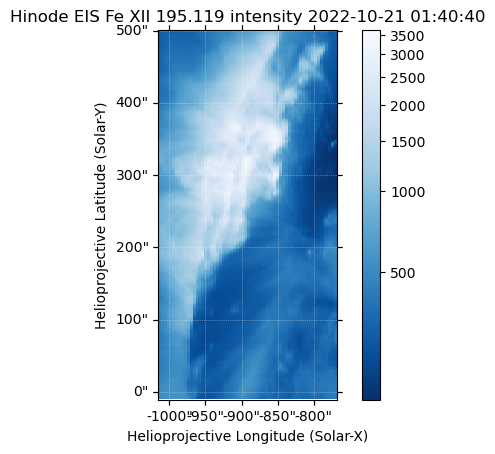

In [4]:
eis_FeXII_195_intmap.plot()
plt.colorbar()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


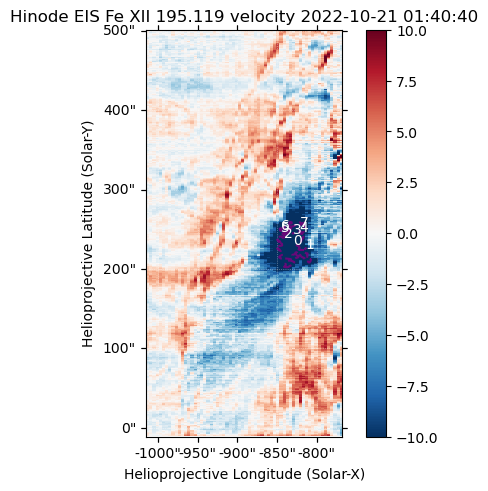

In [5]:
fig = plt.figure(layout='constrained')

ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap)
eis_FeXII_195_velmap.plot(axes=ax)

cs = eis_FeXII_195_velmap.draw_contours(levels=[-15,]*eis_FeXII_195_velmap.unit,colors=["purple"],axes=ax,alpha=0.8)
plt.colorbar()

for ii, seg in enumerate(cs.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

# ax.set_xlim(0,20)
# ax.set_ylim(150,350)

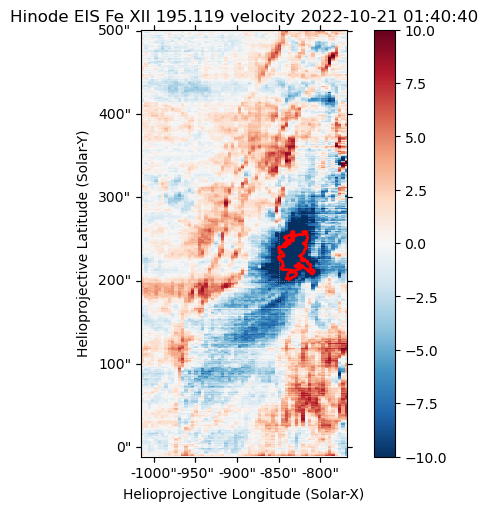

In [6]:
cs_selected_index = [0]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_FeXII_195_velmap)
eis_FeXII_195_velmap.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index:
    ax.plot(*cs.allsegs[0][ii].T, color='red', lw=2)

In [7]:
cs_skycoords = [eis_FeXII_195_velmap.pixel_to_world(cs.allsegs[0][cs_index][:-1,0]*u.pix,cs.allsegs[0][cs_index][:-1,1]*u.pix) \
                for cs_index in cs_selected_index]
cs_regions = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords]

In [8]:
def get_intensity_from_cs_regions(intensity_map, cs_regions):
    intensity = []
    masks = [np.where(cs_region.contains(sunpy.map.all_coordinates_from_map(intensity_map), 
                                                intensity_map.wcs)) for cs_region in cs_regions]
    intensity = [intensity_map.data[mask_] for mask_ in masks]
    return intensity

In [9]:
def mean_intensity_in_region(regions_intensity, min=None, max=None):
    if max is not None:
        for region_intensity in regions_intensity:
            mask = np.where(region_intensity > max)
            region_intensity[mask] = np.nan
    if min is not None:
        for region_intensity in regions_intensity:
            mask = np.where(region_intensity < min)
            region_intensity[mask] = np.nan
    return np.array([np.nanmean(region_intensity) for region_intensity in regions_intensity])

In [10]:
eis_radcal_file = readsav('../../sav/eis_radcal_20221025.sav',verbose=True)

--------------------------------------------------
Date: Thu Jun 27 11:54:26 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 11 records of which:
 - 1 are of type TIMESTAMP
 - 8 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - sw_wvl [<class 'numpy.ndarray'>]
 - lw_wvl [<class 'numpy.ndarray'>]
 - gdz_sw [<class 'numpy.ndarray'>]
 - gdz_lw [<class 'numpy.ndarray'>]
 - hpw_sw [<class 'numpy.ndarray'>]
 - hpw_lw [<class 'numpy.ndarray'>]
 - new_sw [<class 'numpy.ndarray'>]
 - new_lw [<class 'numpy.ndarray'>]
--------------------------------------------------


In [11]:
def get_eis_radcal(wvl,radcal_file=eis_radcal_file,method='hpw'):
    if isinstance(wvl, u.Quantity):
        wvl = wvl.to_value(u.angstrom)
        
    if method == 'hpw':
        lw_radcal = radcal_file['hpw_lw']
        sw_radcal = radcal_file['hpw_sw']
    elif method == 'lpw':
        lw_radcal = radcal_file['lpw_lw']
        sw_radcal = radcal_file['lpw_sw']
    elif method == 'new':
        lw_radcal = radcal_file['new_lw']
        sw_radcal = radcal_file['new_sw']
    
    if 165 < wvl < 212:
        radcal = sw_radcal
        wvl_grid = radcal_file['sw_wvl']
    elif 245 < wvl < 292:
        radcal = lw_radcal
        wvl_grid = radcal_file['lw_wvl']
    else:
        raise ValueError('Wavelength out of range')
    
    radcal_interp_func = scipy.interpolate.interp1d(wvl_grid, radcal, kind='cubic', fill_value='extrapolate')
    return radcal_interp_func(wvl)

In [12]:
eis_FeXII_195_upflow_regions_int = get_intensity_from_cs_regions(eis_FeXII_195_intmap, cs_regions)
eis_FeXII_195_upflow_regions_int_mean = mean_intensity_in_region(eis_FeXII_195_upflow_regions_int)
eis_FeXII_195_upflow_regions_int_mean_radcal = eis_FeXII_195_upflow_regions_int_mean*get_eis_radcal(eis_FeXII_195_intmap.wavelength)

In [13]:
def read_eis_fit_and_return_upflow_int(eis_file_prefix, eis_line_name,cs_regions,
                                       component=0, radcal_file=eis_radcal_file, method='hpw',
                                       int_hist=0, min=None, max=None):
    
    eis_fitres = eispac.read_fit(eis_file_prefix + eis_line_name + '.fit.h5')
    eis_intmap = eis_fitres.get_map(component=component, measurement='intensity')
    eis_intmap.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(eis_intmap.data, 0.5),
                                                      vmax=np.nanpercentile(eis_intmap.data, 99.5),
                                                      stretch=AsinhStretch(0.1))

    eis_regions_int = get_intensity_from_cs_regions(eis_intmap, cs_regions)
    eis_regions_int_mean = mean_intensity_in_region(eis_regions_int, min=min, max=max)
    eis_regions_int_mean_radcal = eis_regions_int_mean*get_eis_radcal(eis_intmap.wavelength,
                                                                      radcal_file=radcal_file, method=method)
    
    fig = plt.figure(figsize=(7, 5),layout='constrained')
    ax = fig.add_subplot(111, projection=eis_intmap)
    eis_intmap.plot(axes=ax)
    plt.colorbar()
    
    for region in cs_regions:
        ax.plot_coord(region.vertices, color='red', lw=2)

    if int_hist is not False:
        if isinstance(int_hist, int) and (0 <= int_hist < len(cs_regions)):
            fig, ax = plt.subplots(layout='constrained')
            ax.hist(eis_regions_int[int_hist], bins=10, histtype='step', color='black', lw=2, 
                    range=(np.nanmin(eis_regions_int[int_hist]),np.nanmax(eis_regions_int[int_hist])))
            
            if min is not None:
                ax.axvline(min, color='red', lw=2, ls='--')
            if max is not None:
                ax.axvline(max, color='red', lw=2, ls='--')

    return eis_regions_int_mean_radcal

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_08_185_213.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


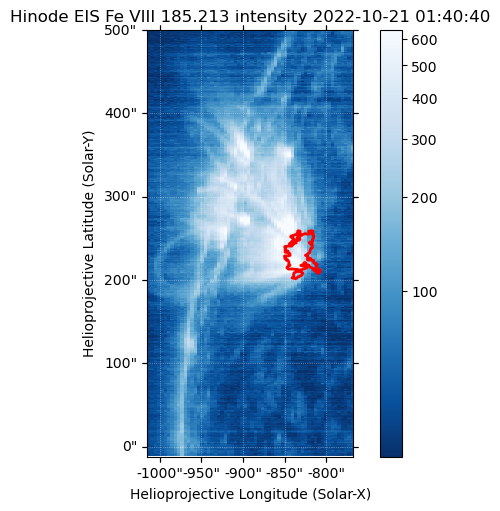

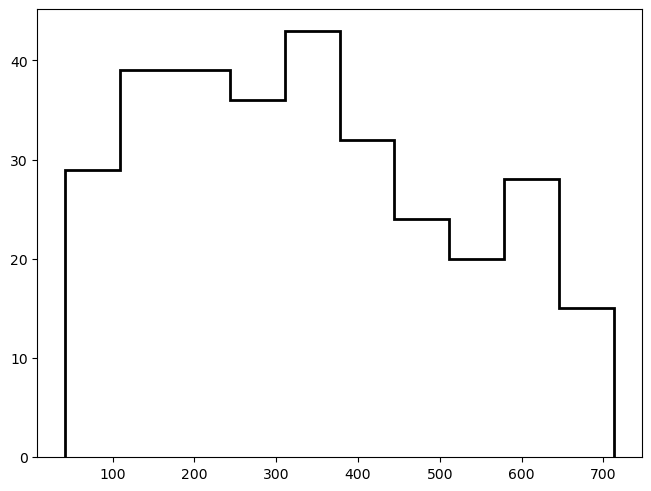

In [14]:
eis_FeVIII_185_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_08_185_213.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_08_186_601.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


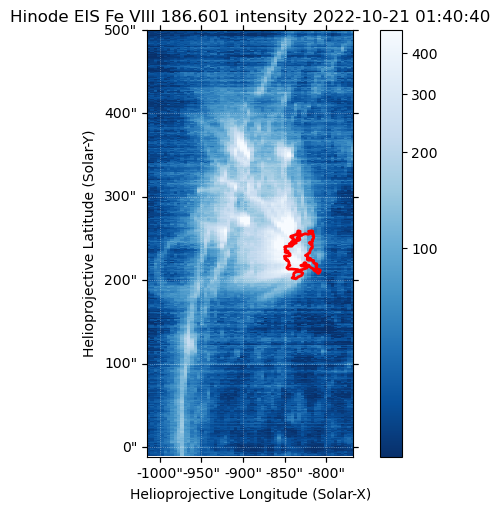

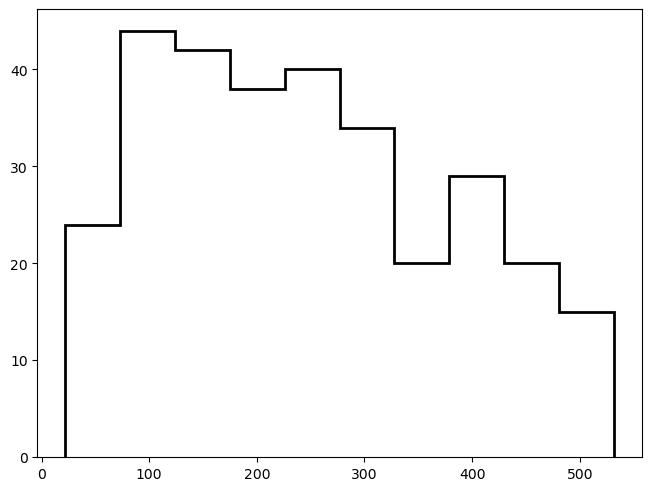

In [15]:
eis_FeVIII_186_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_08_186_601.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_09_188_497.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


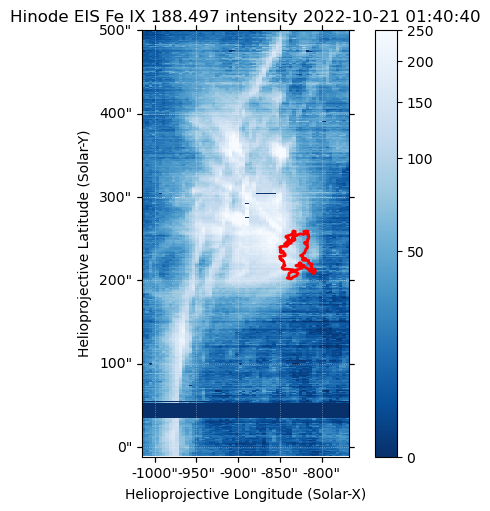

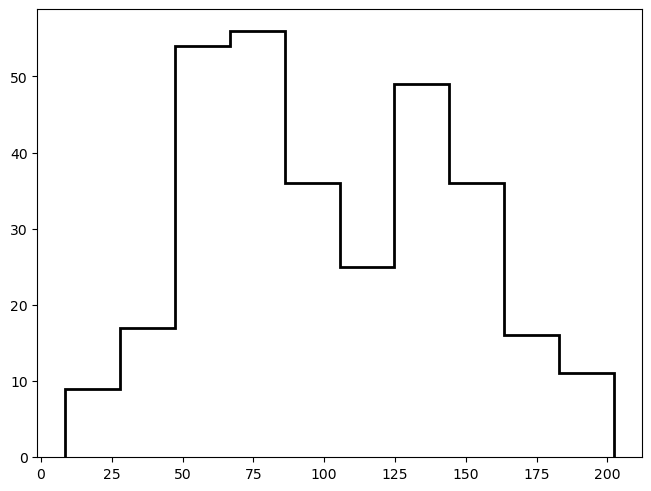

In [16]:
eis_FeIX_188_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_09_188_497.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_09_197_862.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


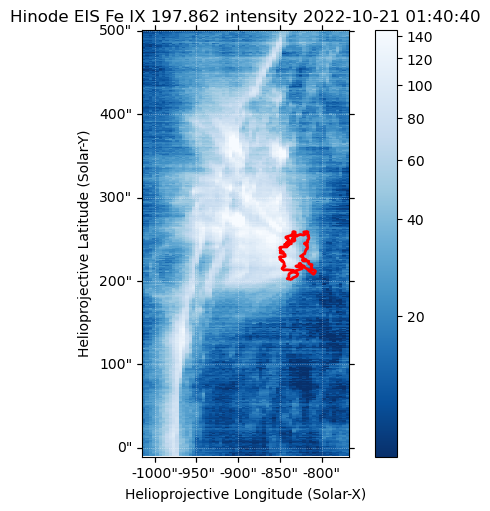

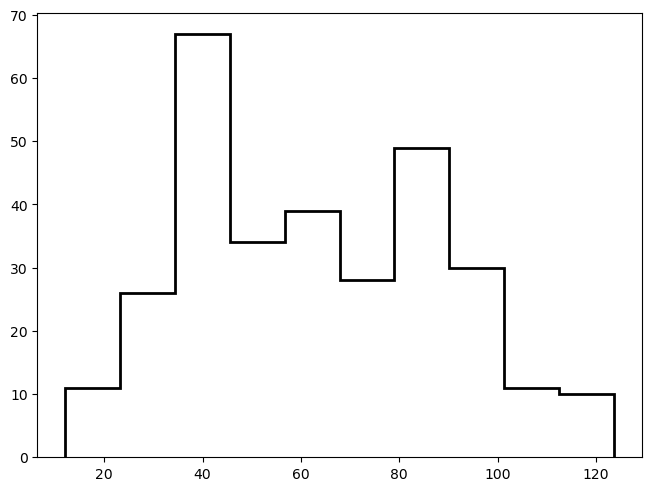

In [17]:
eis_FeIX_197_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_09_197_862.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_10_184_536.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


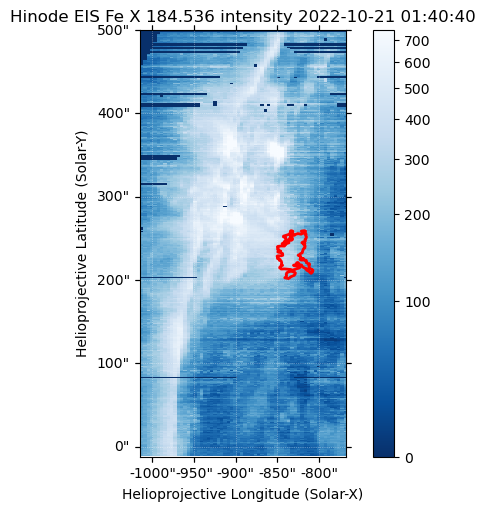

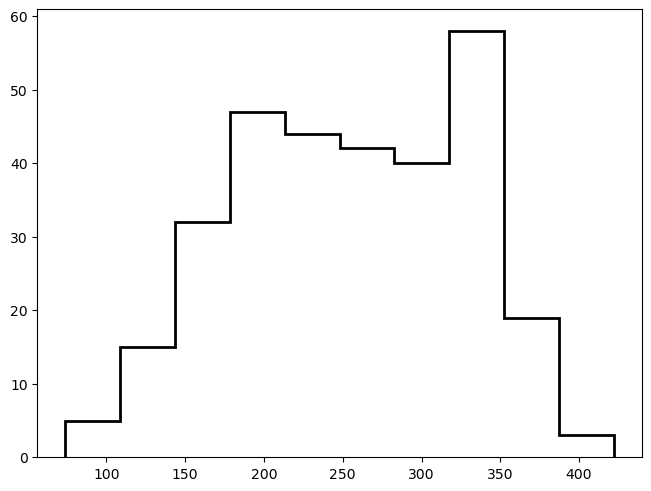

In [18]:
eis_FeX_184_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_10_184_536.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_11_188_216.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


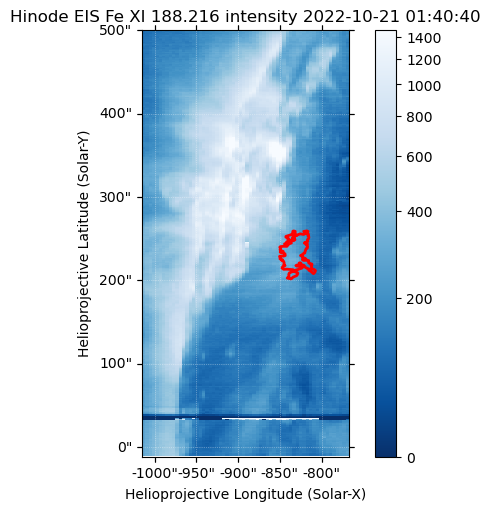

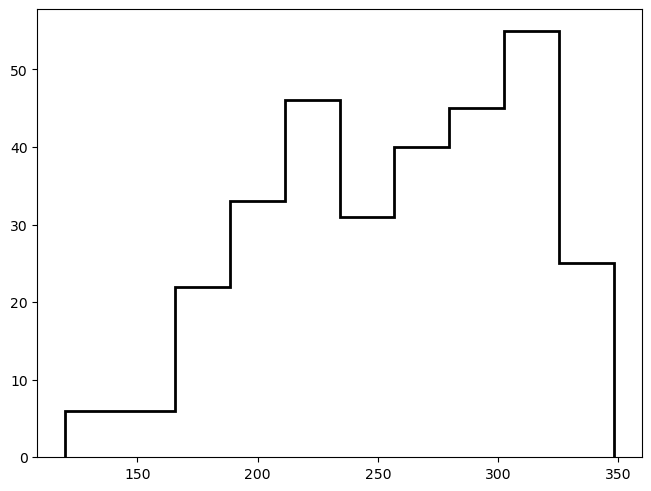

In [19]:
eis_FeXI_188_216_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_11_188_216.2c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_11_188_299.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


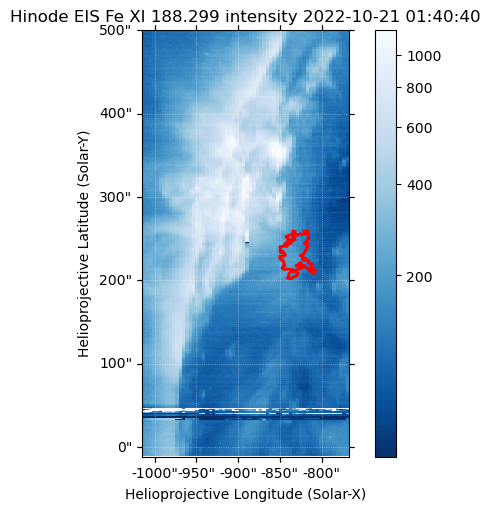

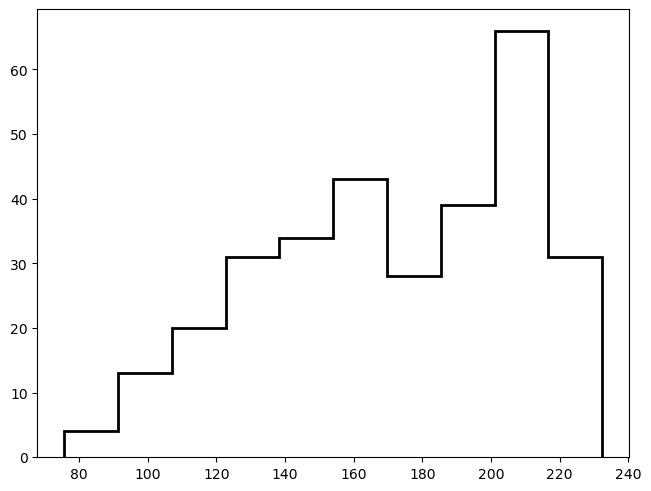

In [20]:
eis_FeXI_188_299_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_11_188_299.2c-1', cs_regions,
                                                                                     component=1)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_12_192_394.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


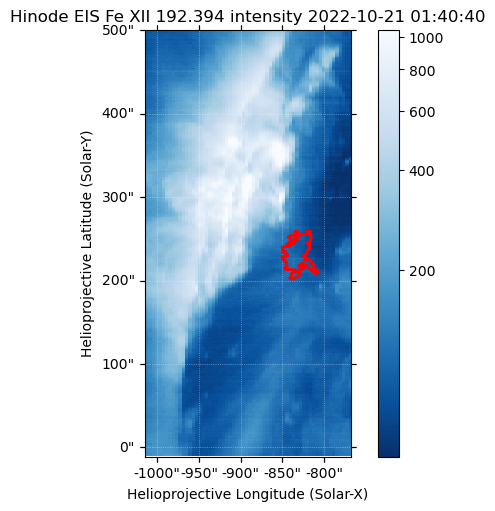

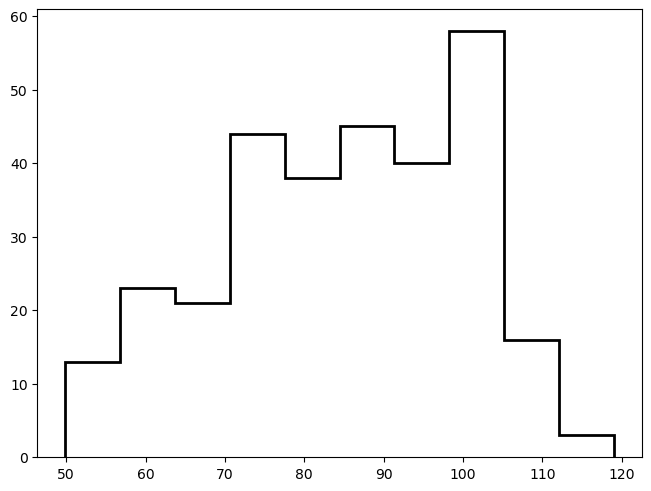

In [21]:
eis_FeXII_192_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_12_192_394.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_13_202_044.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


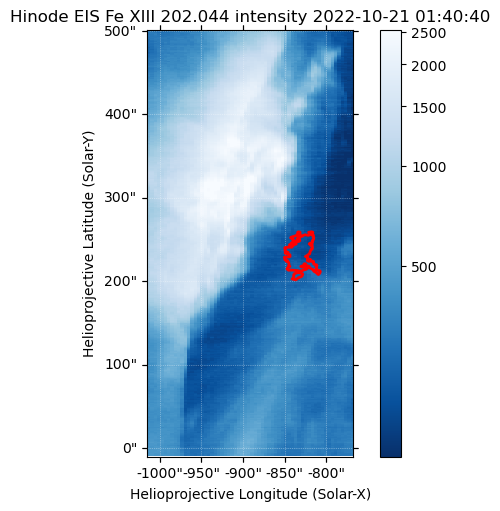

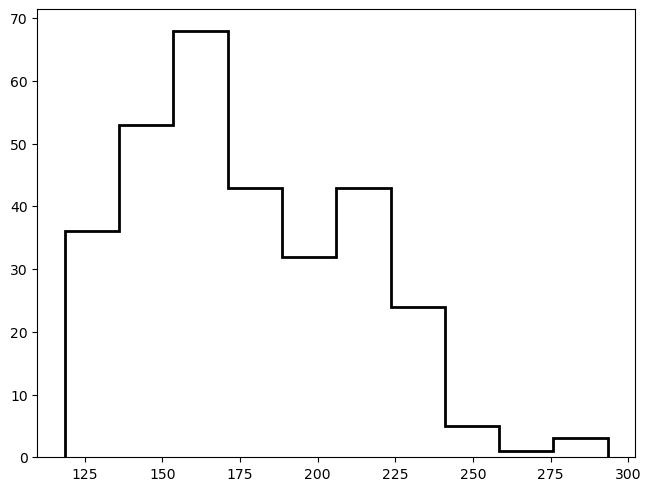

In [22]:
eis_FeXIII_202_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_13_202_044.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_12_203_720.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


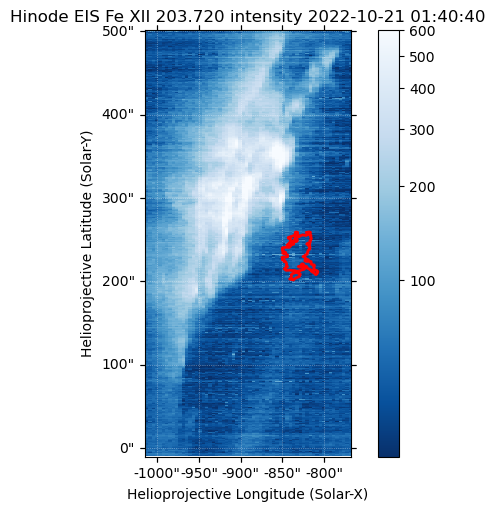

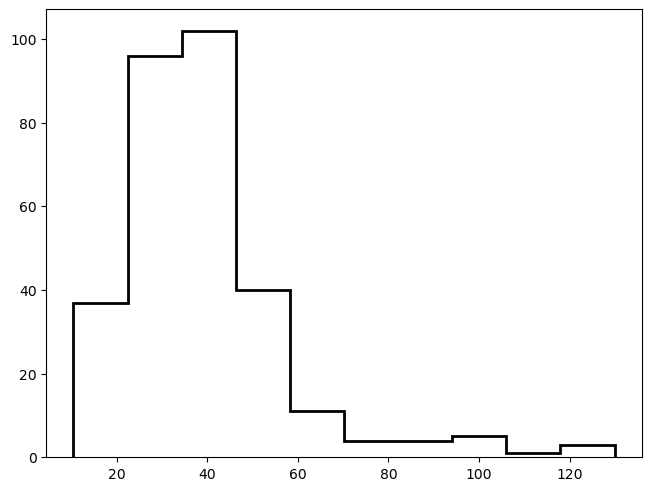

In [23]:
eis_FeXII_203_720_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_12_203_720.2c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_13_203_826.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


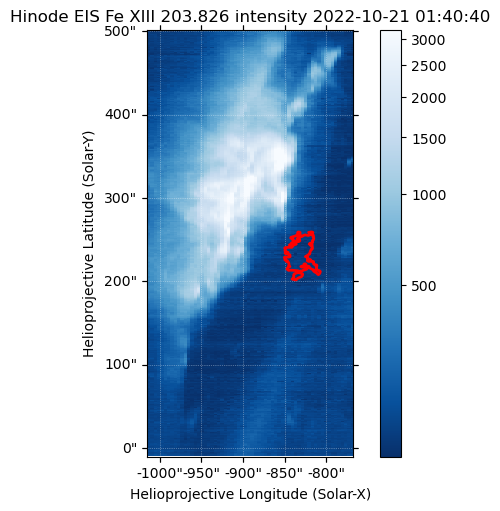

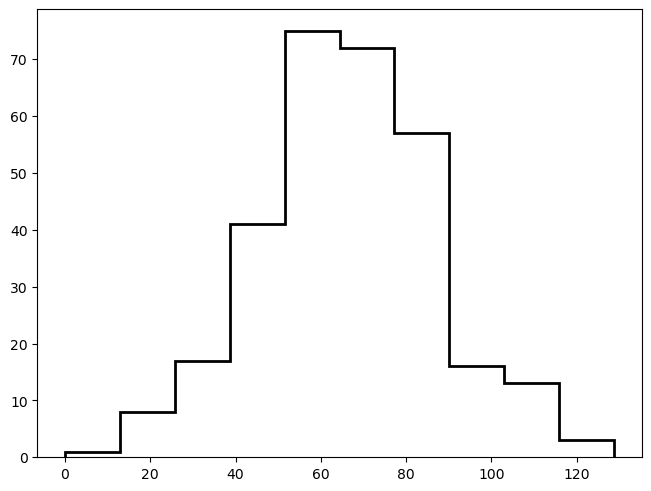

In [24]:
eis_FeXIII_203_826_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_13_203_826.2c-1', cs_regions,
                                                                                       component=1)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_14_264_787.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


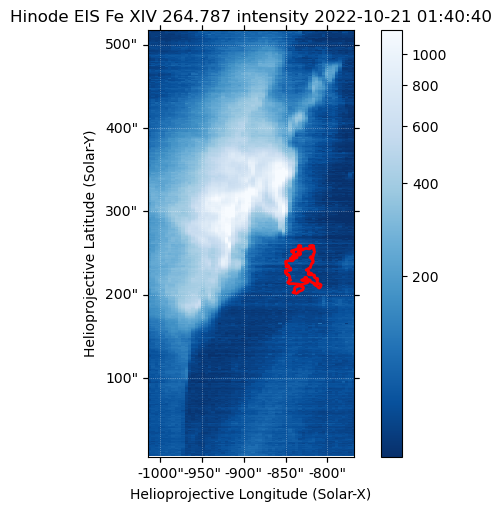

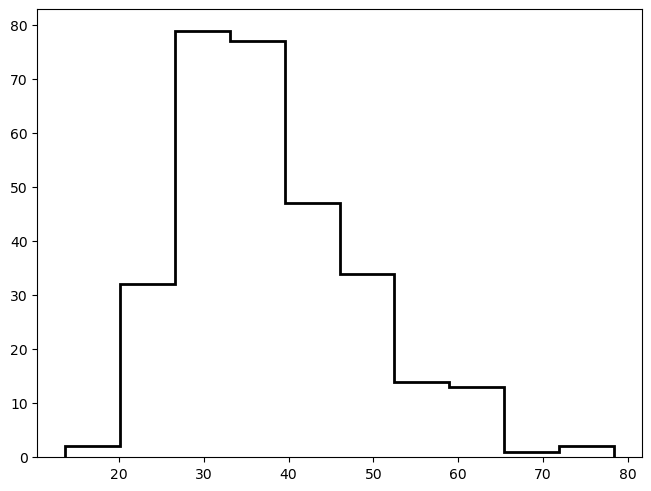

In [43]:
eis_FeXIV_264_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_14_264_787.1c-0', cs_regions,
                                                                                  int_hist=0,)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_14_270_519.2c-1.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


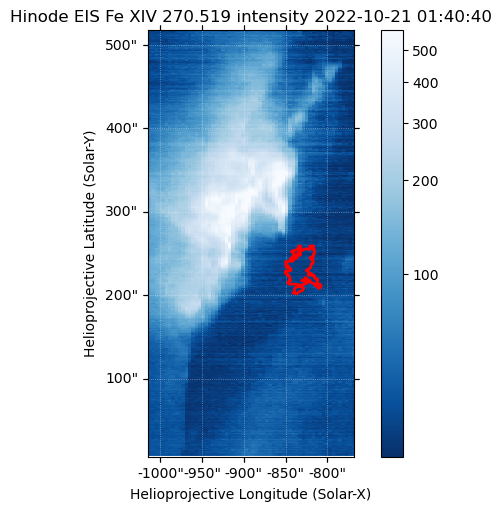

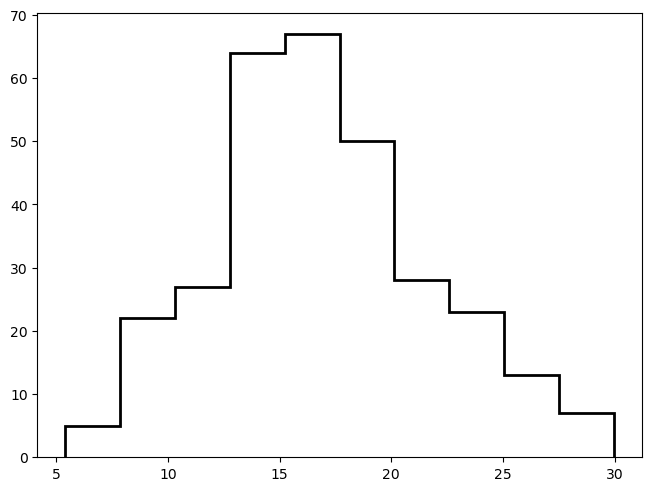

In [26]:
eis_FeXIV_270_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_14_270_519.2c-1', cs_regions,
                                                                                  component=1,int_hist=0)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_15_284_160.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


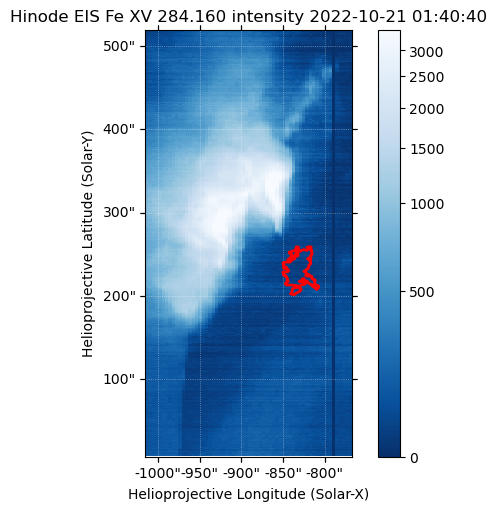

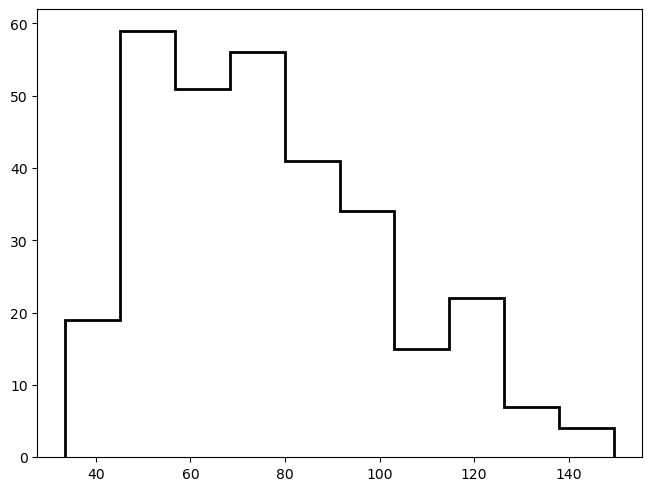

In [27]:
eis_FeXV_284_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_15_284_160.1c-0', cs_regions,
                                                                                 int_hist=0)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.fe_16_262_984.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


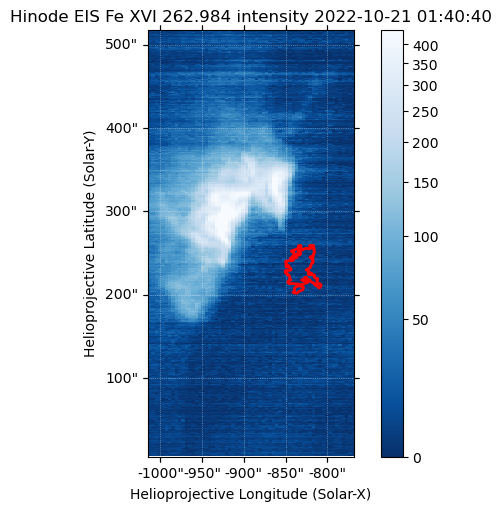

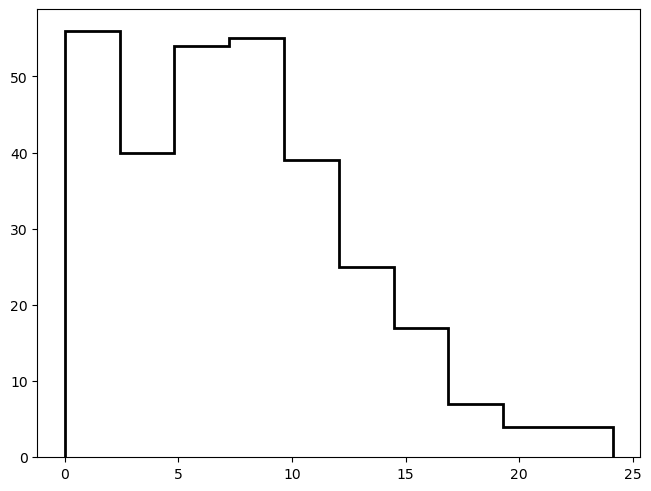

In [28]:
eis_FeXVI_262_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'fe_16_262_984.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.o__04_279_933.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


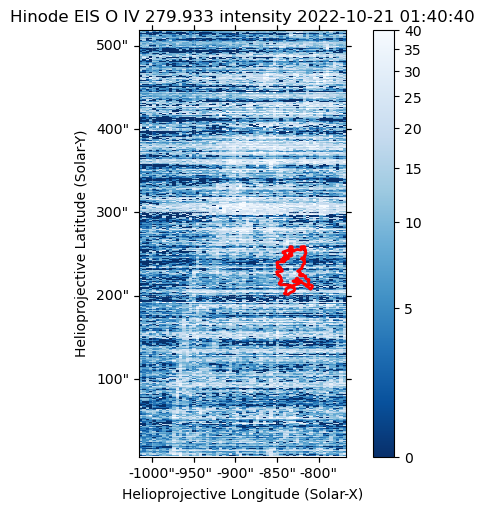

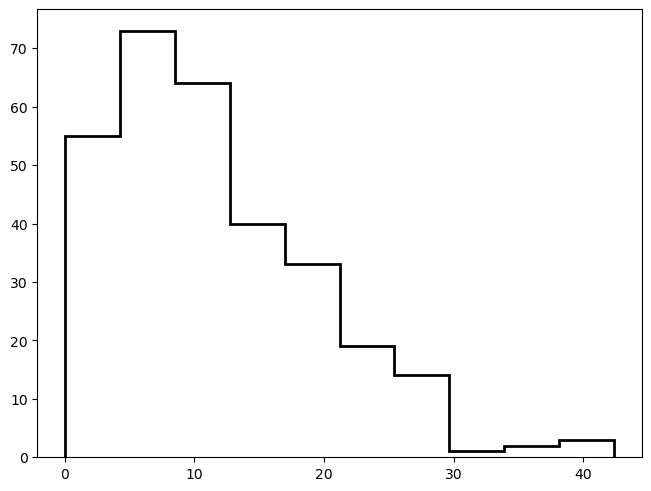

In [29]:
eis_OIV_279_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'o__04_279_933.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.o__06_184_117.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


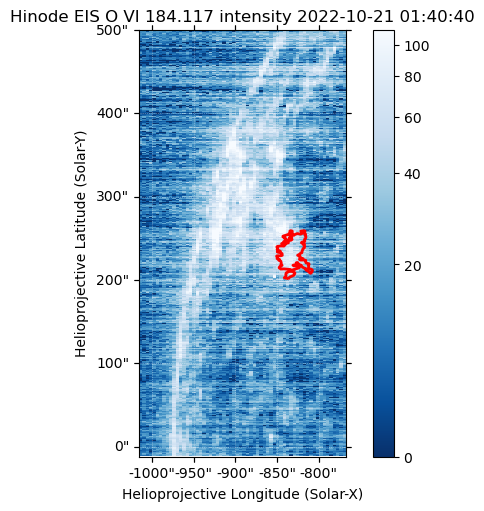

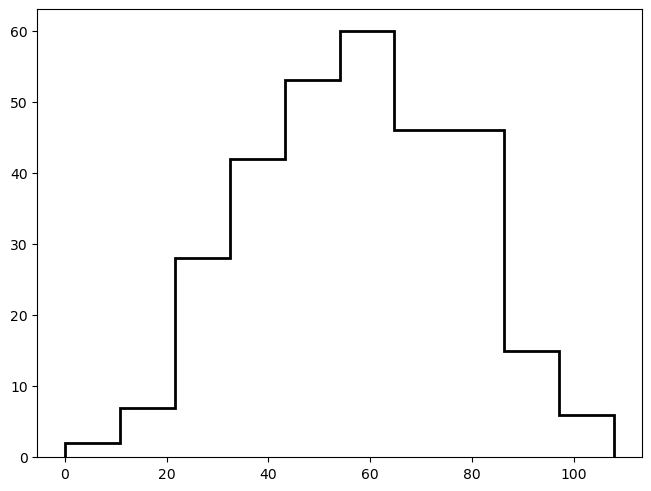

In [30]:
eis_OVI_184_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'o__06_184_117.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.mg_06_270_394.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


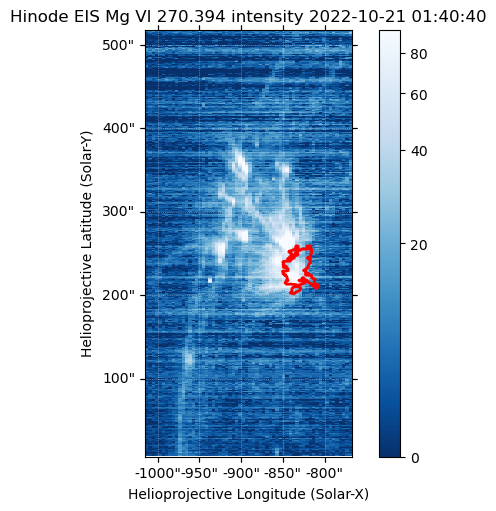

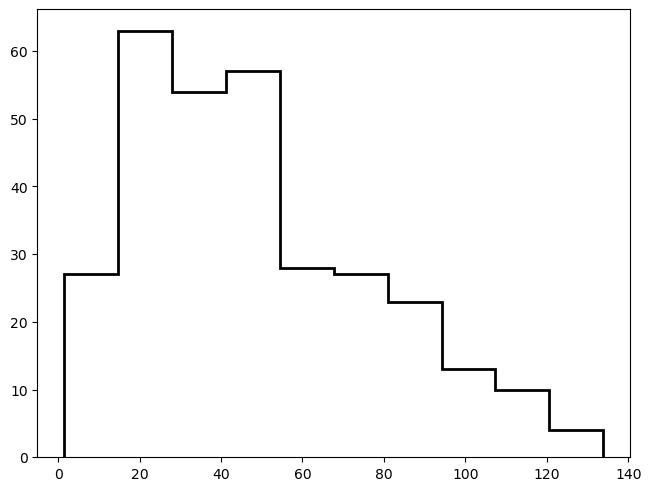

In [31]:
eis_MgVI_270_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'mg_06_270_394.2c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.si_07_275_368.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


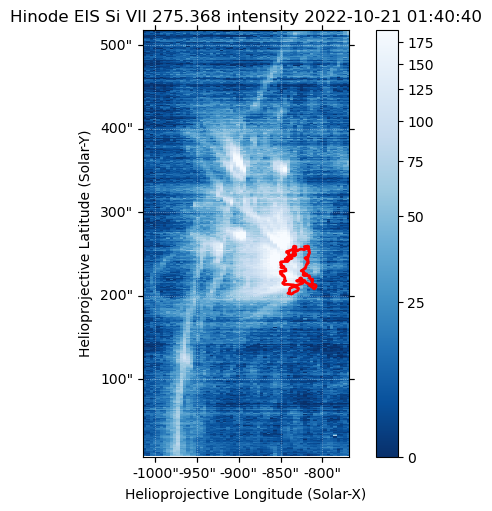

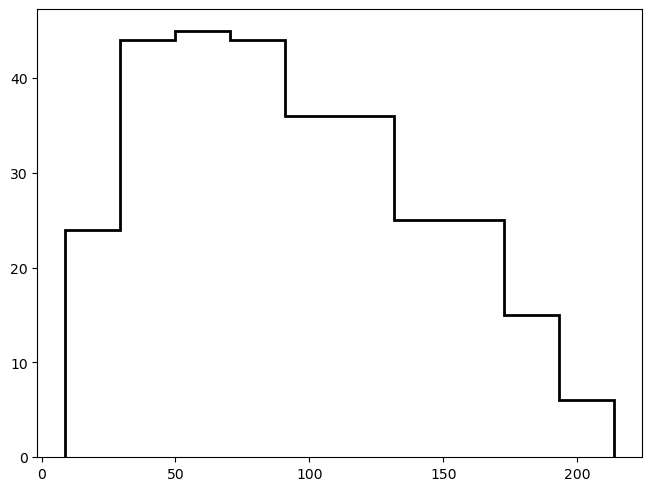

In [32]:
eis_SiVII_275_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'si_07_275_368.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.mg_07_276_153.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


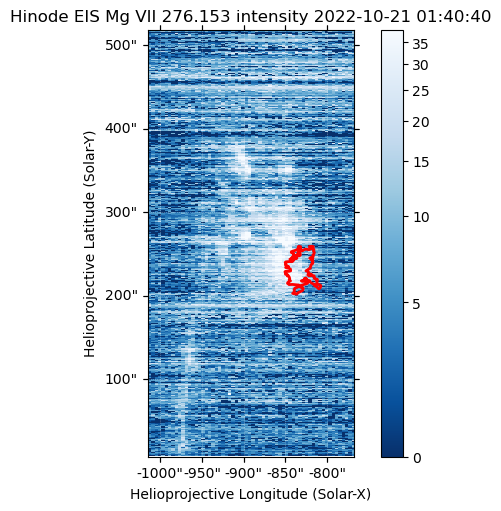

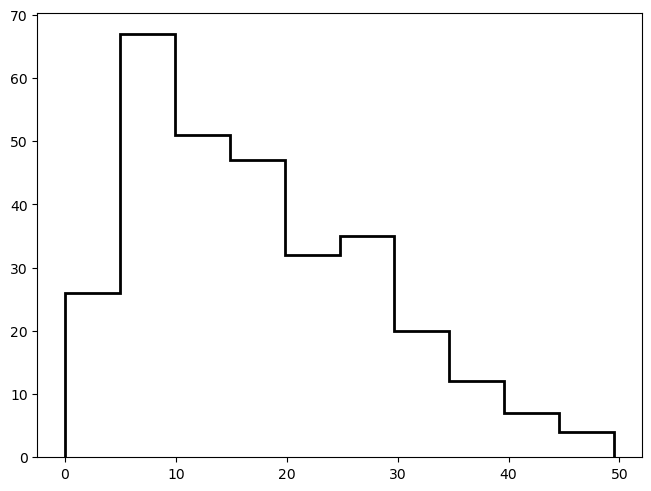

In [33]:
eis_MgVII_276_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'mg_07_276_153.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.mg_07_280_737.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


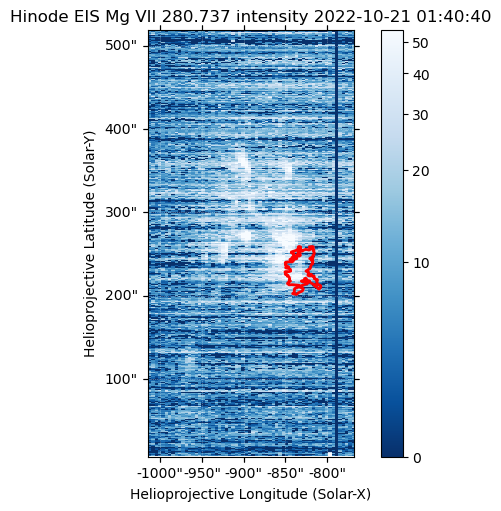

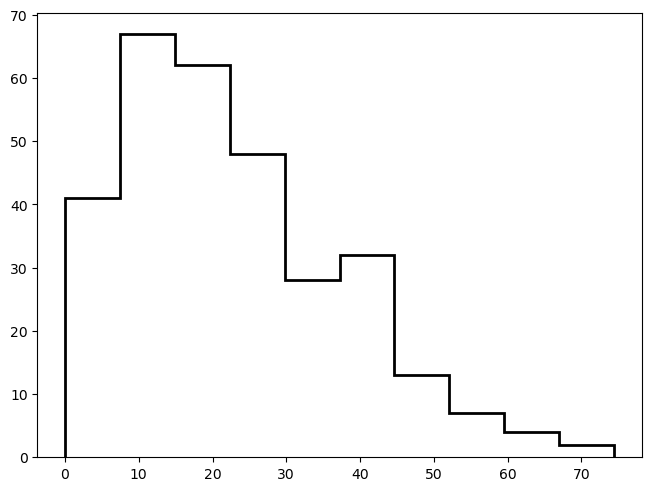

In [34]:
eis_MgVII_280_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'mg_07_280_737.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.si_10_258_375.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


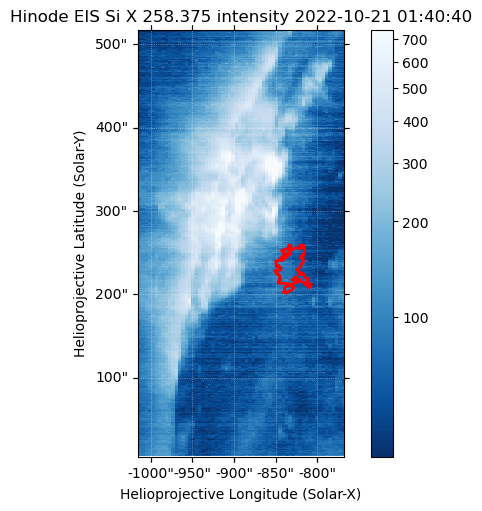

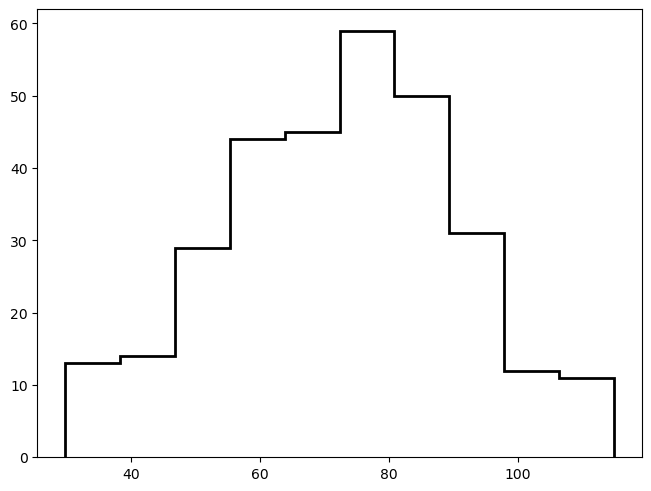

In [35]:
eis_SiX_258_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'si_10_258_375.1c-0', cs_regions)

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T2343/eis_20221021_010842.si_10_261_058.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


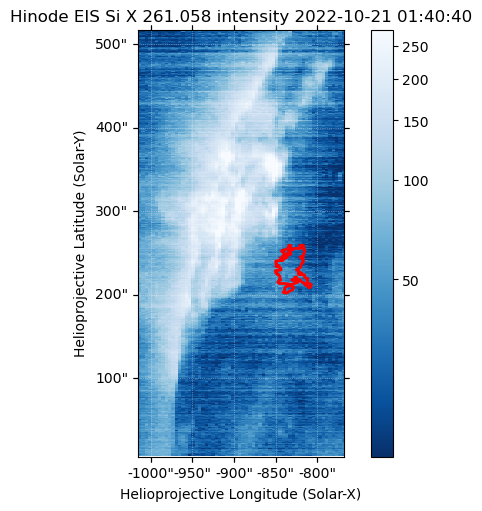

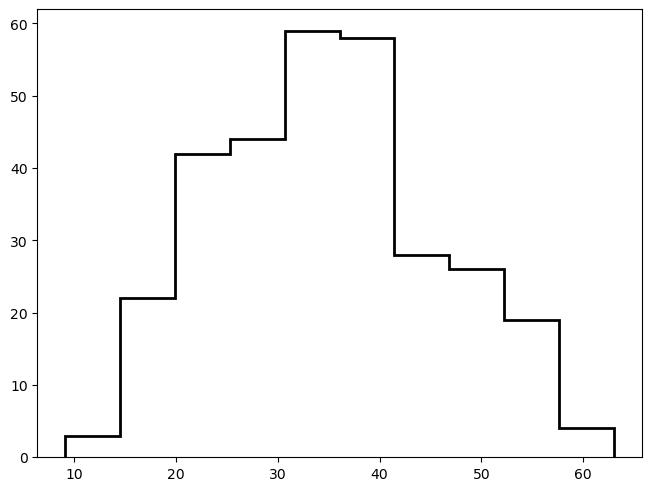

In [36]:
eis_SiX_261_upflow_regions_int_mean_radcal = read_eis_fit_and_return_upflow_int(eis_file_prefix, 'si_10_261_058.1c-0', cs_regions)

In [37]:
def dens_diag(ratio, chianti_file):
    chianti_pf = pd.read_csv(chianti_file,skiprows=6,sep=r'\s+',names=['dens','ratio'])
    chianti_dens, chianti_ratio = chianti_pf['dens'], chianti_pf['ratio']
    dens_interp_func = scipy.interpolate.interp1d(chianti_ratio, chianti_dens, kind='cubic', fill_value='extrapolate')

    return dens_interp_func(ratio)

In [38]:
SiX_dens_upflow_regions = dens_diag(eis_SiX_258_upflow_regions_int_mean_radcal/eis_SiX_261_upflow_regions_int_mean_radcal,
                                    '../../sav/CHIANTI/SiX_285_261_dens.txt')
SiX_dens_upflow_regions

array([1.54582396e+08])

In [39]:
MgVII_dens_upflow_regions = dens_diag(eis_MgVII_276_upflow_regions_int_mean_radcal/eis_MgVII_280_upflow_regions_int_mean_radcal,
                                        '../../sav/CHIANTI/MgVII_276_280.txt')
MgVII_dens_upflow_regions

array([9.46641721e+08])

In [40]:
FeXIII_dens_upflow_regions = dens_diag(eis_FeXIII_202_upflow_regions_int_mean_radcal/eis_FeXIII_203_826_upflow_regions_int_mean_radcal,
                                        '../../sav/CHIANTI/FeXIII_202_203_dens.txt')
FeXIII_dens_upflow_regions

array([2.23791645e+08])

In [41]:
upflow_region_0_dem_wvl = np.array([185.213, 186.598, 188.493, 197.854, 184.537,
                                    188.216, 188.299, 192.394, 195.119, 203.728,
                                    202.044, 203.826, 264.788, 270.520, 284.163, 
                                    262.976])
upflow_region_0_dem_int = np.vstack([eis_FeVIII_185_upflow_regions_int_mean_radcal,
                                     eis_FeVIII_186_upflow_regions_int_mean_radcal,
                                     eis_FeIX_188_upflow_regions_int_mean_radcal,
                                     eis_FeIX_197_upflow_regions_int_mean_radcal,
                                     eis_FeX_184_upflow_regions_int_mean_radcal,
                                     eis_FeXI_188_216_upflow_regions_int_mean_radcal,
                                     eis_FeXI_188_299_upflow_regions_int_mean_radcal,
                                     eis_FeXII_192_upflow_regions_int_mean_radcal,
                                     eis_FeXII_195_upflow_regions_int_mean_radcal,
                                     eis_FeXII_203_720_upflow_regions_int_mean_radcal,
                                     eis_FeXIII_202_upflow_regions_int_mean_radcal,
                                     eis_FeXIII_203_826_upflow_regions_int_mean_radcal,
                                     eis_FeXIV_264_upflow_regions_int_mean_radcal,
                                     eis_FeXIV_270_upflow_regions_int_mean_radcal,
                                     eis_FeXV_284_upflow_regions_int_mean_radcal,
                                     eis_FeXVI_262_upflow_regions_int_mean_radcal])[:,0]

upflow_region_0_dem_int_err = upflow_region_0_dem_int*0.23

upflow_region_0_den_wvl_hwhm = np.ones_like(upflow_region_0_dem_wvl)*0.07

upflow_region_0_dem_des = ['Fe VIII 185', 'Fe VIII 186', 'Fe IX 188', 'Fe IX 197', 'Fe X 184',
                           'Fe XI 188.216', 'Fe XI 188.299', 'Fe XII 192', 'Fe XII 195', 'Fe XII 203.720',
                           'Fe XIII 202', 'Fe XIII 203.826/.795', 'Fe XIV 264', 'Fe XIV 270', 'Fe XV 284',
                           'Fe XVI 262']


In [42]:
upflow_region_0_chianti_input_pf = pd.DataFrame({'wvl':upflow_region_0_dem_wvl,
                                                    'int':upflow_region_0_dem_int,
                                                    'int_err':upflow_region_0_dem_int_err,
                                                    'hwhm':upflow_region_0_den_wvl_hwhm,
                                                    'des':upflow_region_0_dem_des})
upflow_region_0_chianti_input_pf.to_csv('../../sav/CHIANTI/dem_input/west_upflow_region_0_chianti_input_pf.txt',index=False,
                                        header=False, sep=' ',)
upflow_region_0_chianti_input_pf

wvl         int     int_err  hwhm                   des
0   185.213  446.662604  102.732399  0.07           Fe VIII 185
1   186.598  292.345427   67.239448  0.07           Fe VIII 186
2   188.493  104.958438   24.140441  0.07             Fe IX 188
3   197.854   66.514117   15.298247  0.07             Fe IX 197
4   184.537  352.128559   80.989569  0.07              Fe X 184
5   188.216  271.170370   62.369185  0.07         Fe XI 188.216
6   188.299  179.591870   41.306130  0.07         Fe XI 188.299
7   192.394   77.181085   17.751650  0.07            Fe XII 192
8   195.119  289.061131   66.484060  0.07            Fe XII 195
9   203.728   18.885735    4.343719  0.07        Fe XII 203.720
10  202.044  113.817009   26.177912  0.07           Fe XIII 202
11  203.826   31.521721    7.249996  0.07  Fe XIII 203.826/.795
12  264.788  144.391870   33.210130  0.07            Fe XIV 264
13  270.520   80.398223   18.491591  0.07            Fe XIV 270
14  284.163  343.756208   79.063928  0.07             Fe XV 284
15  262.976   24.772274    5.697623  0.07            Fe XVI 262